In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.backend.clear_session()

### dataset information

In [5]:
from datetime import datetime
dataset = 'fmnist'
dims = (28,28,1)
umap_prop = 1.0
num_classes = 10
PROJECTION_DIMS = 128
labels_per_class = 1#'full'
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
print(datestring)

2020_07_30_00_07_17_450537


### Load packages

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [7]:
from tfumap.load_datasets import load_FMNIST, mask_labels

In [8]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_FMNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

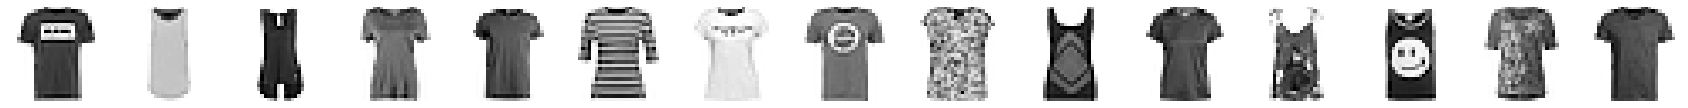

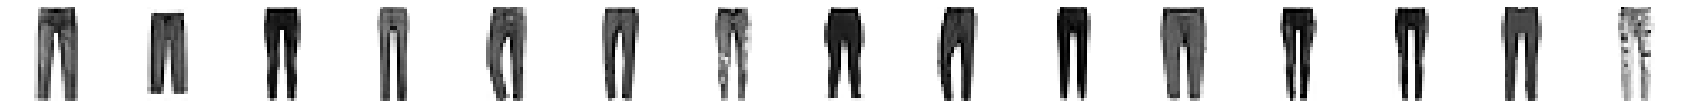

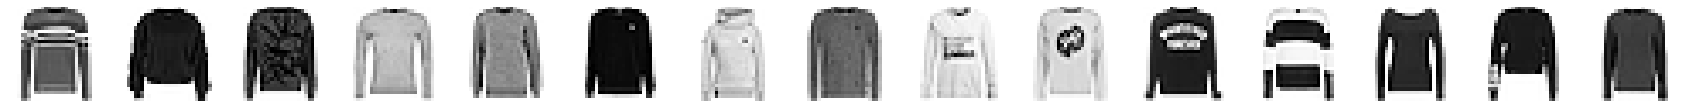

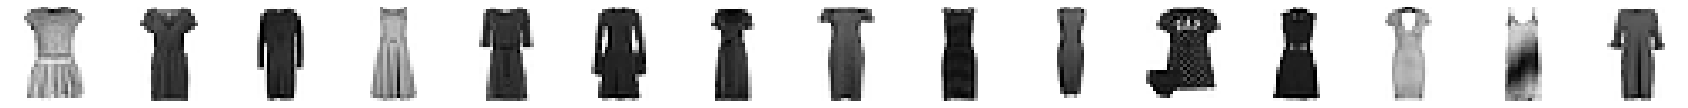

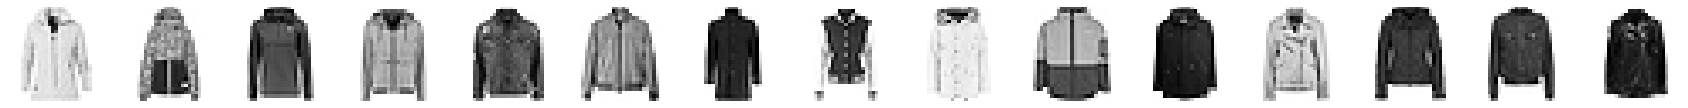

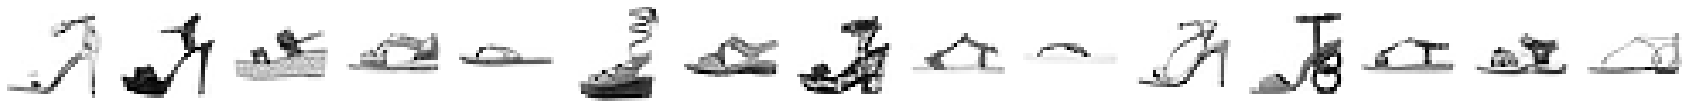

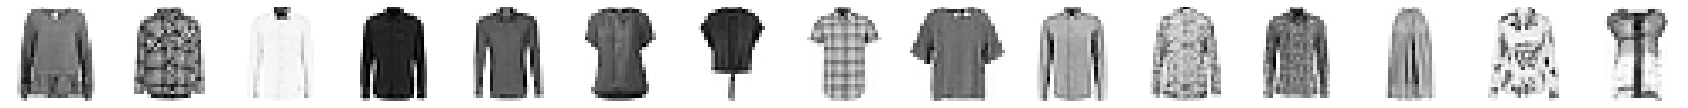

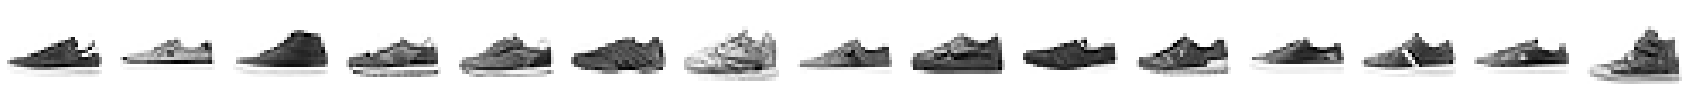

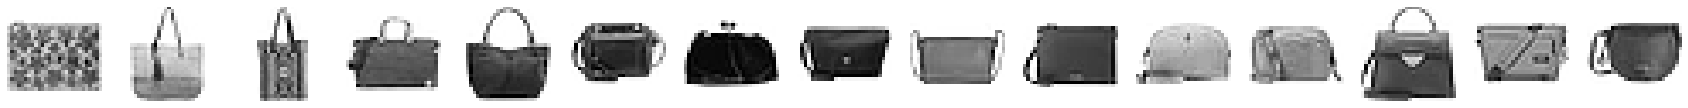

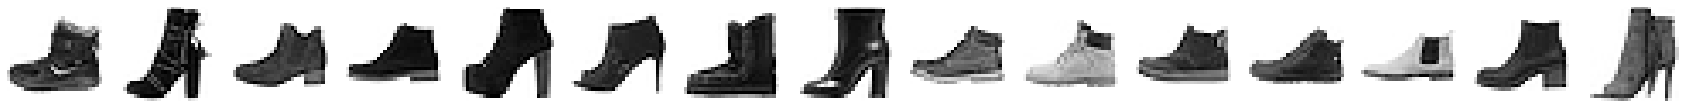

In [9]:
nex = 15
for class_ in np.unique(Y_train):
    exs = X_train[Y_train == class_]
    fig, axs = plt.subplots(ncols=nex, figsize=(nex*2, 2))
    for ax, ex in zip(axs.flatten(), exs):
        ax.matshow(np.squeeze(ex), cmap = plt.cm.Greys)
        ax.axis('off')

#### augment X_train

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
img_data_gen = ImageDataGenerator(
    rotation_range=10,       # random rotation degrees
    width_shift_range=0.1,   # random shift 10%
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range = (0.1, 2),
    ##rescale = 0.1,
    #brightness_range = (0.001, 1),
    zoom_range = 0.2,
    #shear_range = 6,
    ##zca_whitening = True,
)

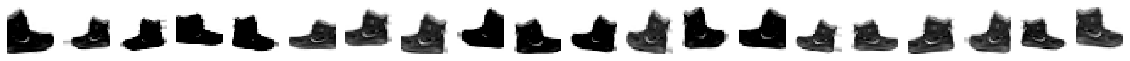

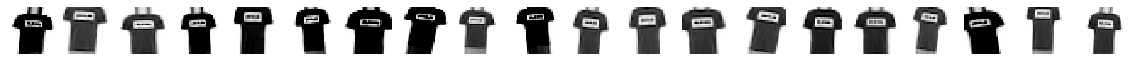

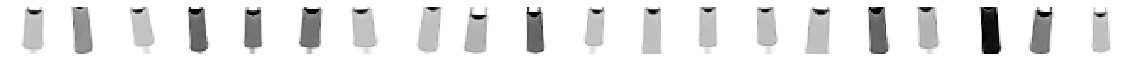

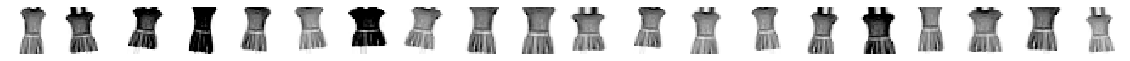

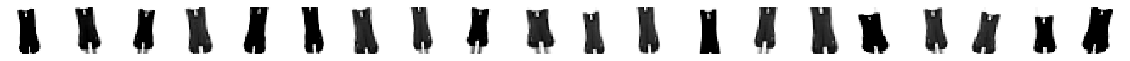

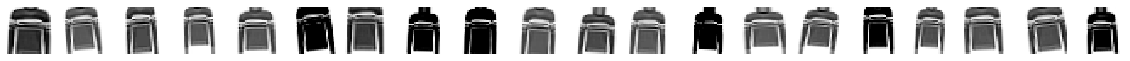

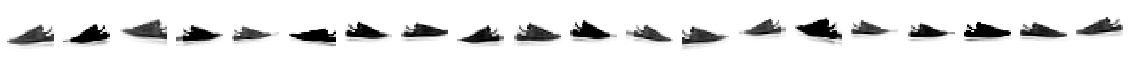

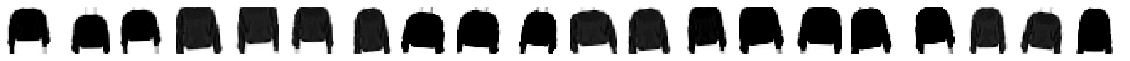

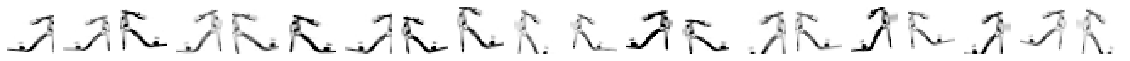

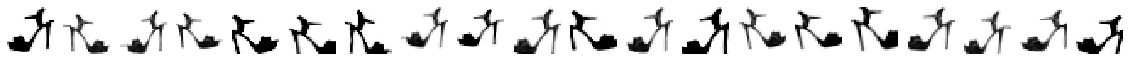

In [12]:
nex = 20
for i in range(10):
    x = X_train[i]
    fig, axs = plt.subplots(nrows=1, ncols=nex, figsize=[nex *1, 1])
    for i, x_ex in enumerate(img_data_gen.flow(np.expand_dims(x,0), batch_size=1)):
        ax = axs[i]
        ax.matshow(np.squeeze(x_ex[0]), cmap=plt.cm.Greys)
        ax.axis('off')
        if i == nex-1:
            break
    plt.show()

In [13]:
batch_generator = img_data_gen.flow(np.expand_dims(x,0), batch_size=32)

In [14]:
img_data_gen

In [15]:
batch_size = 32
labeled_iter = tf.data.Dataset.from_generator(
    lambda: img_data_gen.flow(X_train, y=Y_train, batch_size=batch_size),
    (tf.float32, tf.int32),
)

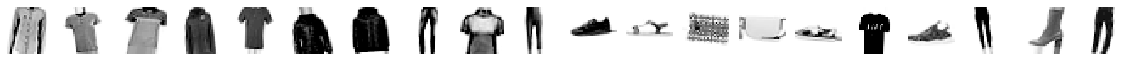

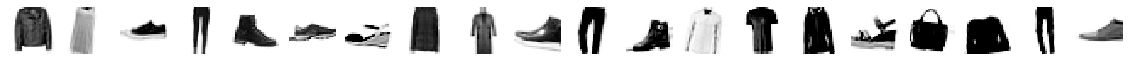

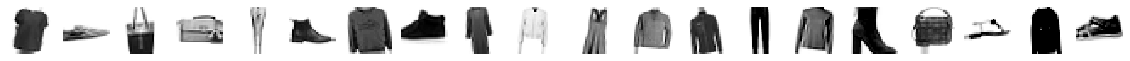

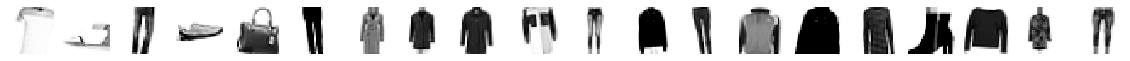

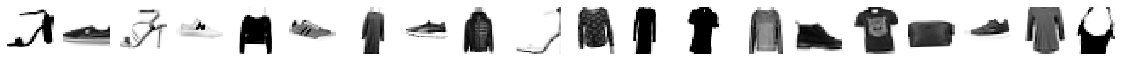

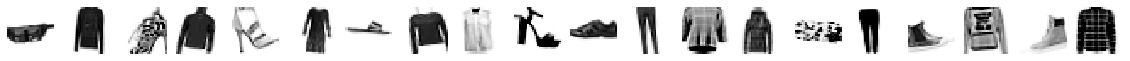

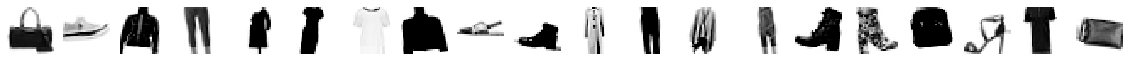

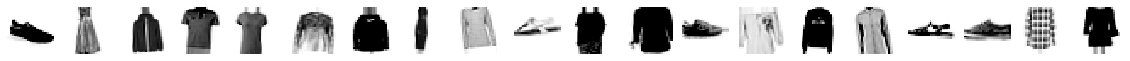

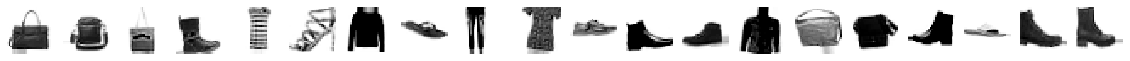

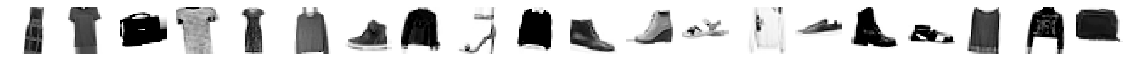

In [16]:
nex = 20
j = 0
for X, y in labeled_iter:
    fig, axs = plt.subplots(nrows=1, ncols=nex, figsize=[nex *1, 1])
    for i, x_ex in enumerate(X):
        ax = axs[i]
        ax.matshow(np.squeeze(x_ex), cmap=plt.cm.Greys)
        ax.axis('off')
        if i == nex-1:
            break
    plt.show()
    j+=1
    if j == 10:
        break

In [17]:
X_train.shape

(50000, 28, 28, 1)

In [18]:
nex

20

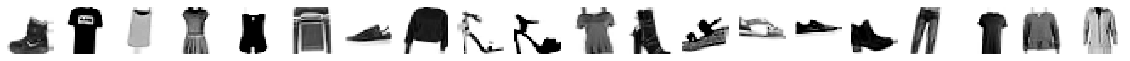

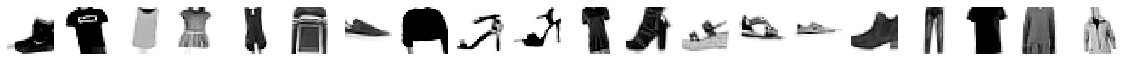

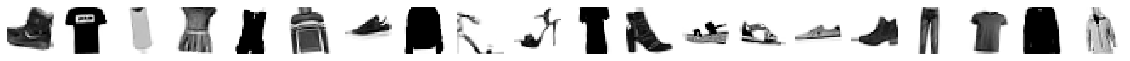

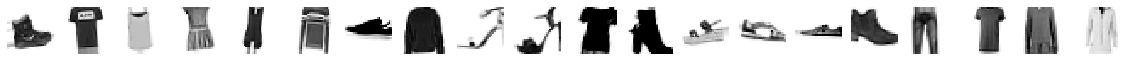

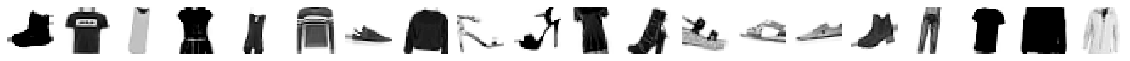

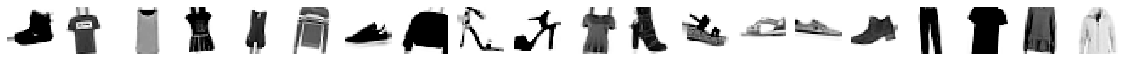

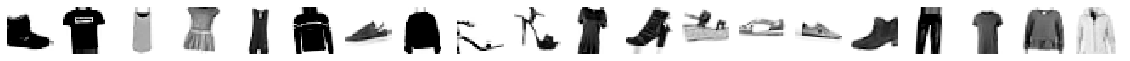

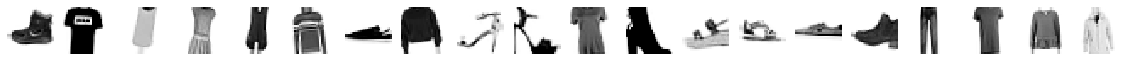

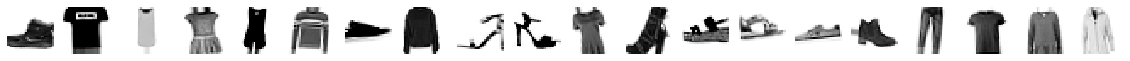

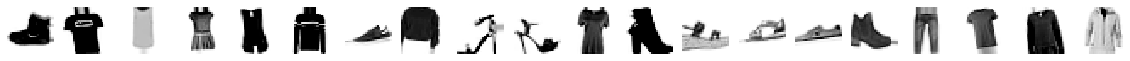

In [20]:
nex = 20
for i in tqdm(range(10)):
    x_gen = next(img_data_gen.flow(X_train[:nex], shuffle=False))
    fig, axs = plt.subplots(nrows=1, ncols=nex, figsize=[nex *1, 1])
    for i, x_ex in enumerate(x_gen):
        ax = axs[i]
        ax.matshow(np.squeeze(x_ex), cmap=plt.cm.Greys)
        ax.axis('off')
        if i == nex-1:
            break
    plt.show()
    j+=1


In [21]:
X_train[0].shape

(28, 28, 1)

In [22]:
np.repeat(np.expand_dims(X_train[0],0), 10, axis=0).shape

(10, 28, 28, 1)

In [23]:
x_gen = tf.image.random_brightness(np.repeat(np.expand_dims(X_train[1],0), 20, axis=0), max_delta = 5)
x_gen.shape

TensorShape([20, 28, 28, 1])

In [24]:
x = np.repeat(np.expand_dims(X_train[1],0), 20, axis=0)
x = tf.image.resize_with_crop_or_pad(x, 34, 34) 
x_gen = tf.image.random_crop(x, size=[20, 28, 28, 1])
x_gen.shape

TensorShape([20, 28, 28, 1])

In [25]:
tf.__version__

'2.3.0'

In [26]:
tf.random.Generator = None
import tensorflow_addons as tfa

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


<tf.Tensor: shape=(), dtype=float32, numpy=1.768193>

In [61]:
def augment(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.resize_with_crop_or_pad(x, 34, 34) 
    x = tf.image.random_crop(x, size=[28, 28, 1])
    ##x = tf.image.random_brightness(x, max_delta = 1.0)
    #x = tf.image.random_contrast(x, lower=0, upper = 10)
    #x = tf.image.adjust_brightness(x, np.random.rand(1)[0])
    # adjust brightness
    x = tf.clip_by_value(x * tf.random.uniform(shape = [], minval=0.25, maxval=2), 0, 1)
    # contrast
    x = tf.clip_by_value(x ** tf.random.uniform(shape = [], minval=0.5, maxval=2), 0, 1)
    #x = tfa.image.rotate(x, np.random.rand(1)[0]*.1)
    #x = tfa.image.shear_x(x, .1, 0)
    return x

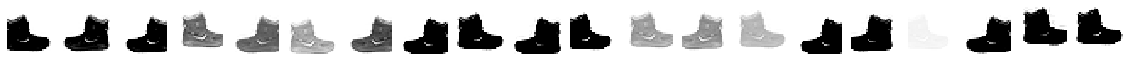

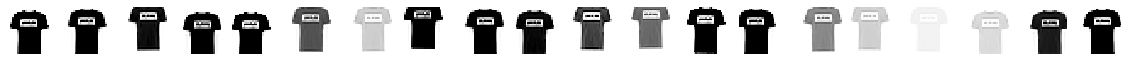

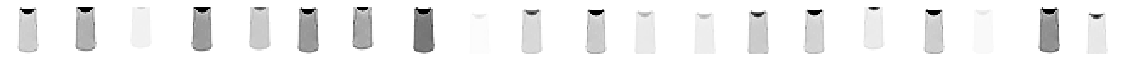

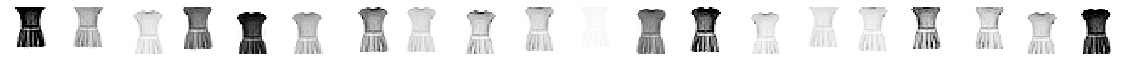

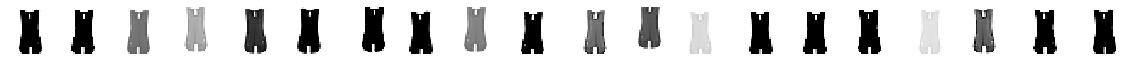

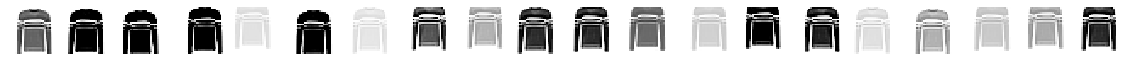

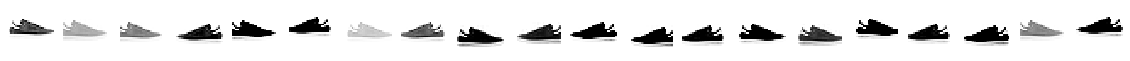

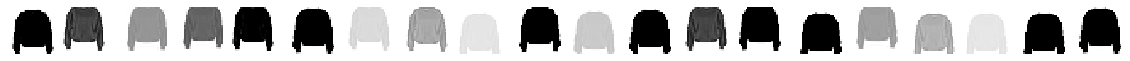

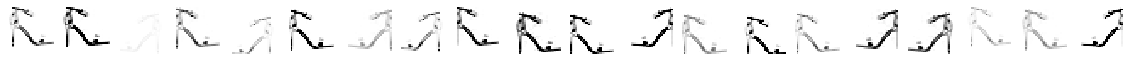

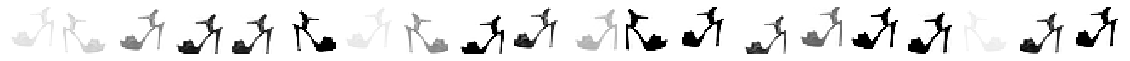

In [62]:
for j in range(10):
    x = np.repeat(np.expand_dims(X_train[j],0), 20, axis=0)
    x_gen = tf.map_fn(lambda img: augment(img), x)

    fig, axs = plt.subplots(nrows=1, ncols=nex, figsize=[nex *1, 1])
    for i, x_ex in enumerate(x_gen):
        ax = axs[i]
        ax.matshow(np.squeeze(x_ex), cmap=plt.cm.Greys, vmin=0, vmax=1)
        ax.axis('off')
        if i == nex-1:
            break
    plt.show()
